<a href="https://colab.research.google.com/github/SajindraDasuniM/Book_Recommendation_System/blob/main/A1_Recommender_system_Sajindra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Import relevant libraries

Schools usually rely on the same publisher for textbooks even when the curriculum is
changed. Publishers cannot be easily changed as it requires significant investment of time by the
school staff. This is due to the unavailability of list of textbooks suitable for each subject and grade.
Therefore, this report will discuss how a textbook recommender system can be developed using
Natural Language Processing(NLP) to recommend the suitable books and predict the subject of
the book based on a book description given.     

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import relevant libraries
import requests
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # needed for WordNetLemmatizer in newer NLTK versions

from sklearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Import the existing book dataset and analyse

In [8]:
# Data Generation
# Initialize provided data
# Load the sheet that likely contains the ISBN data
df_isbn = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MA5851_Data Science Master Class 1/Week4/A1_Data (1).xlsx", sheet_name='ISBN_Data')
# Display the first few rows to understand its structure
df_isbn.head()
# Extract the list of ISBNs
isbn_list = df_isbn['ISBN'].tolist()

In [ ]:
print(df_isbn.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   School_ID  1804 non-null   int64 
 1   State      1804 non-null   object
 2   Year       1804 non-null   int64 
 3   Subject    1804 non-null   object
 4   ISBN       1804 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 70.6+ KB
None


In [ ]:
df_isbn.head()


,School_ID,State,Year,Subject,ISBN
0,8,VIC,0,ENGLISH,9781741250879
1,9,NSW,0,ENGLISH,9780648237327
2,15,NSW,0,ENGLISH,9781742990682
3,15,NSW,0,ENGLISH,9781741351750
4,15,NSW,0,ENGLISH,9781742152196


In [ ]:
print(df_isbn.describe())

         School_ID         Year          ISBN
count  1804.000000  1804.000000  1.804000e+03
mean     16.894678     9.200111  9.776955e+12
std      12.003466     3.394129  1.827630e+11
min       1.000000     0.000000  2.019052e+12
25%       6.000000     7.000000  9.780196e+12
50%      12.000000    11.000000  9.780995e+12
75%      27.000000    12.000000  9.781741e+12
max      40.000000    12.000000  9.798708e+12


In [ ]:
print(f"dataset size: {df_isbn.shape}")
print("")
print(f"null values: {df_isbn.isnull().sum().sum()}") # no missing data in original dataset
print('')
print(f"NA values: {df_isbn.isna().sum().sum()}") # No NA values
print("")
print(df_isbn["Subject"].value_counts()) # We are trying to predict the Subject. Therefore, dataset is highly inbalanced. There are four subjects: HOME ECONOMICS, WORK STUDIES, ENGINEERING STUDIES and PHILOSOPHY which are having only one record.
print("")
print(df_isbn["Year"].value_counts())


dataset size: (1804, 5)

null values: 0

NA values: 0

Subject
ENGLISH                     567
MATHEMATICS                 284
LANGUAGES                   241
SCIENCE                     223
HISTORY                      73
ENGLISH LITERARY STUDIES     49
BUSINESS STUDIES             38
MUSIC                        32
DRAMA                        29
ACCOUNTING                   29
PSYCHOLOGY                   27
RELIGIOUS EDUCATION          26
PDHPE                        26
LEGAL STUDIES                26
GEOGRAPHY                    24
HUMANITIES                   23
ECONOMICS                    17
COMPUTER SCIENCE             15
DESIGN AND TECHNOLOGY        13
FOOD TECHNOLOGY              11
VISUAL ARTS                   8
ENVIRONMENTAL SCIENCE         6
POLITICS AND LAW              4
AGRICULTURE                   3
english                       2
DANCE                         2
MEDIA                         2
HOME ECONOMICS                1
WORK STUDIES                  1
ENGINEERI

### Collect the metadata from Googlebook API

In [ ]:
# Google Books API Function
def get_google_book_details(isbn):
    # Define the URL for the Google Books API with the provided ISBN
    url = f'https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}'
    # Send a GET request to the Google Books API
    response = requests.get(url)
    # Check if the response status code is 200 (OK)
    if response.status_code == 200:
        # Parse the JSON response
        book_data = response.json()
        # Check if the 'items' key is present in the response
        if 'items' in book_data:
            # Extract the first item's volume information
            book_info = book_data['items'][0]['volumeInfo']
            # Return a dictionary with the relevant book details
            return {
                'title': book_info.get('title'),            # Book title
                'authors': book_info.get('authors'),        # List of authors
                'publishedDate': book_info.get('publishedDate'),  # Publication date
                'description': book_info.get('description'),      # Book description
                'categories': book_info.get('categories'),        # List of categories
                'averageRating': book_info.get('averageRating')   # Average rating
            }
    # Return None if the response status code is not 200 or 'items' key is not present
    return None

In [ ]:
# Function to iterate through ISBN list and collect book details
def collect_book_details(isbn_list):
    # Initialize an empty list to store book details
    book_details_list = []
    # Iterate over each ISBN in the provided list
    for isbn in isbn_list:
        # Attempt to get book details from Google Books API
        book_details = get_google_book_details(isbn)

        # If no details are found continue
        if book_details is None:
            continue

        book_details['isbn'] = isbn
        book_details_list.append(book_details)


    # Return the list of book details
    return book_details_list

google_book_details = collect_book_details(isbn_list)

In [ ]:
google_book_details = pd.DataFrame(google_book_details)
google_book_details.to_excel("google_book_details.xlsx", index = False)

# Collect data from openlibrary

In [ ]:
# Fetch books using Openlibrary

import requests

def extract_description(desc):
    if isinstance(desc, dict):
        return desc.get("value")
    return desc

def get_book_openlibrary(isbn):
    url = "https://openlibrary.org/api/books"
    params = {
        "bibkeys": f"ISBN:{isbn}",
        "format": "json",
        "jscmd": "data"
    }
    r = requests.get(url, params=params)#.json()
    if r.status_code != 200:
        return None

    data = r.json()
    key = f"ISBN:{isbn}"

    if key not in data:
        return None

    b = data[key]

# ---- WORK-LEVEL DESCRIPTION ----
    description = None
    works = b.get("works")
    if works:
        work_key = works[0].get("key")
        if work_key:
            work_url = f"https://openlibrary.org{work_key}.json"
            wr = requests.get(work_url)
            if wr.status_code == 200:
                work = wr.json()
                description = extract_description(work.get("description"))

    return {
        "isbn": isbn,
        "title": b.get("title", ""),
        "authors": [a["name"] for a in b.get("authors", [])],
        "published": b.get("publish_date", ""),
        "publisher": ", ".join(p["name"] for p in b.get("publishers", [])),
        #     if isinstance(b.get("publisher"), str)
        #     else ", ".join(p.get("name", "") for p in b.get("publisher", []))
        # ),
        "description": description or ""
        # "description": (
        #     b["description"]["value"]
        #     if isinstance(b.get("description"), dict)
        #     else b.get("description", "")
        # )
    }


# Search books using openlibrary
openlibrary_book_details = []
for isbn in isbn_list:
  book = get_book_openlibrary(isbn)
  if book:
        openlibrary_book_details.append(book)

print(openlibrary_book_details)

In [ ]:

for i in openlibrary_book_details:
  if i == None:
    openlibrary_book_details.remove(i)
openlibrary_book_details = [i for i in openlibrary_book_details if i is not None]

openlibrary_book_details = pd.DataFrame(openlibrary_book_details)
#openlibrary_book_details.to_excel("openlibrary_book_details.xlsx", index=False)
openlibrary_book_details.head()

# Combine details from two sources

In [7]:
# cretae dataframes from saved Excel files
google_book_details = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MA5851_Data Science Master Class 1/Week4/book_details_from_urls/google_book_details.xlsx")
openlibrary_book_details = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MA5851_Data Science Master Class 1/Week4/book_details_from_urls/openlibrary_books_details.xlsx")

In [ ]:
print(f"google dataframe shape: {google_book_details.shape}")
print(f"openlibrary dataframe shape: {openlibrary_book_details.shape}")
print(f"Googlebook missing values: {google_book_details.isnull().sum()}")
print(f"Openlibrary missing values: {openlibrary_book_details.isnull().sum()}")

google dataframe shape: (831, 8)
openlibrary dataframe shape: (816, 6)
Googlebook missing values: Unnamed: 0         0
title              0
authors           77
publishedDate      2
description      260
categories       288
averageRating    775
isbn               0
dtype: int64
Openlibrary missing values: isbn             0
title            0
authors          0
published      206
publisher      816
description    816
dtype: int64


Description is not available for all openlibrary dataset

In [ ]:
google_book_details.head()


,Unnamed: 0,title,authors,publishedDate,description,categories,averageRating,isbn
0,0,Victorian Targeting Handwriting,"['Jane Pinsker', 'Tricia Dearborn', 'Jo Ryan',...",2004,NaN,['Penmanship'],NaN,9781741250879
1,1,Kluwell My Home Reading Yellow Level,"['Stan Kluzek', 'Andrew Coldwell']",2019-07,Suitable for lower primary students.,NaN,NaN,9780648237327
2,2,Wilfrid Gordon McDonald Partridge,['Mem Fox'],2014,30TH ANNIVERSARY EDITION. Wilfrid Gordon McDon...,NaN,NaN,9781742990682
3,3,IMaths,"['Mary Serenc', 'Lena Ford', 'Chris Linthorne']",2011,"""iMaths is an investigative-based numeracy pro...",['Mathematics'],NaN,9781741351750
4,4,Targeting Maths,['Katy Pike'],2013-08-30,The Australian Curriculum Edition TARGETING MA...,['Mathematics'],NaN,9781742152196


In [ ]:
openlibrary_book_details.head()

,isbn,title,authors,published,publisher,description
0,9780143785996,Boy Behind the Curtain,['Tim Winton'],2017,NaN,NaN
1,9781935753230,Pony Play,"['J. M. Snyder', 'J.M. Snyder']",2010,NaN,NaN
2,9781108707343,Panorama Francophone 2 Coursebook,"['Danile Bourdais', 'Sue Finnie', 'Genevive Ta...",2019,NaN,NaN
3,9780804845588,Beginning Japanese Workbook,"['Michael L. Kluemper', 'Lisa Berkson', 'Natha...",2016,NaN,NaN
4,9781488617492,Ecco! uno Activity Book,[],NaN,NaN,NaN


Googlebooks has 831 ISBNs found and it has description whereas Openlibrary dataframe has no description and it has 816 ISBNs. Therefore, GoogleBook is used as the primary source when combining details.

In [8]:
# merge data
merged = pd.merge(  # out is used to keep all data
    google_book_details,
    openlibrary_book_details,
    on="isbn",
    how="outer",
    suffixes=("_gb", "_ol")
)
merged = pd.DataFrame(merged)
merged.shape
merged.head()

,Unnamed: 0,title_gb,authors_gb,publishedDate,description_gb,categories,averageRating,isbn,title_ol,authors_ol,published,publisher,description_ol
0,345.0,Howl's Moving Castle,['Diana Wynne Jones'],2000,Now an animated movie from Studio Ghibli and H...,['Juvenile Fiction'],NaN,9780006755234,Howl's moving castle,['Diana Wynne Jones'],2005,NaN,NaN
1,258.0,The Giver,['Lois Lowry'],2003-01-01,"YA. It's a perfect world, where everything loo...",['English fiction'],NaN,9780007141425,The Giver Collins Modern Classics,['Lois Lowry'],2002-12-31,NaN,NaN
2,148.0,The Butterfly Lion,['Michael Morpurgo'],2011,Bertie rescues an orphaned lion cub from the A...,"[""Children's stories""]",NaN,9780007456208,Butterfly Lion (Collector's Edition),"['Michael Morpurgo', 'Christian Birmingham', '...",2011,NaN,NaN
3,381.0,Italian Dictionary,"['Collins', 'Collins Dictionaries']",2013,A modern Italian Dictionary offering excellent...,['English language'],NaN,9780007485505,Collins pocket Italian dictionary,['Collins Dictionaries'],2013,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9780007548675,All the Light We Cannot See,['Anthony Doerr'],2014,NaN,NaN


In [9]:
# remove published date since its not important for book classification based on text
merged_new = merged.drop(columns=["publishedDate", "published",'averageRating',"publisher"])
merged_new = merged_new.drop(merged_new.columns[0], axis=1) #drop first columns

merged_new.head()

,title_gb,authors_gb,description_gb,categories,isbn,title_ol,authors_ol,description_ol
0,Howl's Moving Castle,['Diana Wynne Jones'],Now an animated movie from Studio Ghibli and H...,['Juvenile Fiction'],9780006755234,Howl's moving castle,['Diana Wynne Jones'],NaN
1,The Giver,['Lois Lowry'],"YA. It's a perfect world, where everything loo...",['English fiction'],9780007141425,The Giver Collins Modern Classics,['Lois Lowry'],NaN
2,The Butterfly Lion,['Michael Morpurgo'],Bertie rescues an orphaned lion cub from the A...,"[""Children's stories""]",9780007456208,Butterfly Lion (Collector's Edition),"['Michael Morpurgo', 'Christian Birmingham', '...",NaN
3,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,['English language'],9780007485505,Collins pocket Italian dictionary,['Collins Dictionaries'],NaN
4,NaN,NaN,NaN,NaN,9780007548675,All the Light We Cannot See,['Anthony Doerr'],NaN


In [10]:
# Prefer Google Books fields (with fallback to Openlibrary)
merged_new["title"] = merged_new["title_gb"].combine_first(merged_new["title_ol"])
merged_new["authors"] = merged_new["authors_gb"].combine_first(merged_new["authors_ol"])
merged_new["description"] = merged_new["description_gb"].combine_first(merged_new["description_ol"])

# Drop duplicate columns
merged_final = merged_new.drop(
    columns=[
        "title_gb", "title_ol",
        "authors_gb", "authors_ol",
        "description_gb", "description_ol"
    ]
)
merged_final.to_excel("merged_final.xlsx", index=False)
merged_final.head()


,categories,isbn,title,authors,description
0,['Juvenile Fiction'],9780006755234,Howl's Moving Castle,['Diana Wynne Jones'],Now an animated movie from Studio Ghibli and H...
1,['English fiction'],9780007141425,The Giver,['Lois Lowry'],"YA. It's a perfect world, where everything loo..."
2,"[""Children's stories""]",9780007456208,The Butterfly Lion,['Michael Morpurgo'],Bertie rescues an orphaned lion cub from the A...
3,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...
4,NaN,9780007548675,All the Light We Cannot See,['Anthony Doerr'],NaN


In [11]:
# Data wrangling
# Load the data
df_book_details = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/MA5851_Data Science Master Class 1/Week4/merged_final.xlsx')
print(f"size after merging two sources: {df_book_details.shape}")
print("")
print(f"missing values after merging two sources: {df_book_details.isnull().sum()}")
# Data cleaning
df_book_details.drop_duplicates(inplace=True) # remove duplicate rows
print("")
print(f"size after removing duplicates after merging two sources: {df_book_details.shape}")

# Convert missing text to empty strings (instead of dropping to avoid data loss)
text_cols = ["title", "description", "authors", "categories"]
df_book_details[text_cols] = df_book_details[text_cols].fillna("")
#df_book_details.dropna(subset=['title', 'description'], inplace=True)

# Combine the dataframes
# Rename columns to have consistent naming conventions if necessary
df_book_details.rename(columns={'isbn': 'ISBN'}, inplace=True)
# Merge the url data with original dataset on the 'ISBN' column
df_combined = pd.merge(df_book_details, df_isbn, on='ISBN', how='inner')

print("")
# Display the combined dataframe
print(f"size after combining with original school dataset: {df_combined.shape}")





size after merging two sources: (1197, 5)

missing values after merging two sources: categories     654
isbn             0
title            0
authors         21
description    626
dtype: int64

size after removing duplicates after merging two sources: (950, 5)

size after combining with original school dataset: (1646, 9)


In [12]:
# combine the fields: title, authors,description, categories to create a new combined text field

# Initially need to convert all fields to string before combining. For example field which has lists such as authers etc will be converetd to text and missing values will be replaced with "". We need to fill missing values before applying TF-IDF
def to_text(x):
    if isinstance(x, list):
        return " ".join(x)
    if pd.isna(x): # remove null values
        return ""
    return str(x)

text_cols = ["title", "authors", "description", "categories"]
for col in text_cols:
    df_combined[col] = df_combined[col].apply(to_text)

# Then cobine all fields to one text. Give more weights to important fields
df_combined['combined_text'] = (
    (df_combined['title'] + ' ')*3 +
    (df_combined['authors'] + ' ')*2 +
    (df_combined['categories'] + ' ')*3 +
    df_combined['description']
)

df_combined.head()

,categories,ISBN,title,authors,description,School_ID,State,Year,Subject,combined_text
0,['Juvenile Fiction'],9780006755234,Howl's Moving Castle,['Diana Wynne Jones'],Now an animated movie from Studio Ghibli and H...,5,VIC,9,ENGLISH,Howl's Moving Castle Howl's Moving Castle Howl...
1,['English fiction'],9780007141425,The Giver,['Lois Lowry'],"YA. It's a perfect world, where everything loo...",10,VIC,7,ENGLISH,The Giver The Giver The Giver ['Lois Lowry'] [...
2,"[""Children's stories""]",9780007456208,The Butterfly Lion,['Michael Morpurgo'],Bertie rescues an orphaned lion cub from the A...,15,NSW,4,ENGLISH,The Butterfly Lion The Butterfly Lion The Butt...
3,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,28,SA,8,LANGUAGES,Italian Dictionary Italian Dictionary Italian ...
4,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,28,SA,9,LANGUAGES,Italian Dictionary Italian Dictionary Italian ...


# Text preprocessing

In [13]:

# Normalize text
def normalize_text(text):
    # Convert the text to lowercase
    text = text.lower()
    # Replace all non-word characters (anything other than a-z, A-Z, 0-9, and underscores) with a space
    text = re.sub(r'\W', ' ', text)
    # Replace one or more whitespace characters with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_combined['combined_text'] = df_combined['combined_text'].apply(normalize_text)
df_combined.head()

,categories,ISBN,title,authors,description,School_ID,State,Year,Subject,combined_text
0,['Juvenile Fiction'],9780006755234,Howl's Moving Castle,['Diana Wynne Jones'],Now an animated movie from Studio Ghibli and H...,5,VIC,9,ENGLISH,howl s moving castle howl s moving castle howl...
1,['English fiction'],9780007141425,The Giver,['Lois Lowry'],"YA. It's a perfect world, where everything loo...",10,VIC,7,ENGLISH,the giver the giver the giver lois lowry lois ...
2,"[""Children's stories""]",9780007456208,The Butterfly Lion,['Michael Morpurgo'],Bertie rescues an orphaned lion cub from the A...,15,NSW,4,ENGLISH,the butterfly lion the butterfly lion the butt...
3,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,28,SA,8,LANGUAGES,italian dictionary italian dictionary italian ...
4,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,28,SA,9,LANGUAGES,italian dictionary italian dictionary italian ...


In [14]:
import nltk
nltk.download('punkt_tab') # added this line
# Tokenization and stopwords removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the input text into individual words
    tokens = word_tokenize(text)

    # Lemmatize each token and remove stop words
    # This creates a list of words that are lemmatized and are not in the stop words list
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join the tokens back into a single string separated by spaces
    return ' '.join(tokens)

# # Add description_length to df_combined before sampling
df_combined['combined_text_length'] = df_combined['combined_text'].apply(len)

# Sample data for comparison
sample_size = 100
df_sample = df_combined.sample(n=sample_size, random_state=1)

# Apply preprocessing to sample and full corpus
df_sample['processed_combined_text'] = df_sample['combined_text'].apply(preprocess_text)
df_combined['processed_combined_text'] = df_combined['combined_text'].apply(preprocess_text)

df_combined.to_excel("df_combined.xlsx")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print(df_combined.shape)
df_combined.head()

(1646, 12)


,categories,ISBN,title,authors,description,School_ID,State,Year,Subject,combined_text,combined_text_length,processed_combined_text
0,['Juvenile Fiction'],9780006755234,Howl's Moving Castle,['Diana Wynne Jones'],Now an animated movie from Studio Ghibli and H...,5,VIC,9,ENGLISH,howl s moving castle howl s moving castle howl...,1011,howl moving castle howl moving castle howl mov...
1,['English fiction'],9780007141425,The Giver,['Lois Lowry'],"YA. It's a perfect world, where everything loo...",10,VIC,7,ENGLISH,the giver the giver the giver lois lowry lois ...,377,giver giver giver lois lowry lois lowry englis...
2,"[""Children's stories""]",9780007456208,The Butterfly Lion,['Michael Morpurgo'],Bertie rescues an orphaned lion cub from the A...,15,NSW,4,ENGLISH,the butterfly lion the butterfly lion the butt...,474,butterfly lion butterfly lion butterfly lion m...
3,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,28,SA,8,LANGUAGES,italian dictionary italian dictionary italian ...,1776,italian dictionary italian dictionary italian ...
4,['English language'],9780007485505,Italian Dictionary,"['Collins', 'Collins Dictionaries']",A modern Italian Dictionary offering excellent...,28,SA,9,LANGUAGES,italian dictionary italian dictionary italian ...,1776,italian dictionary italian dictionary italian ...


# EDA

In [ ]:

# EDA
# Descriptive Statistics
# Display descriptive statistics for the sample
print("Descriptive Statistics for the Sample:")
sample_stats = df_sample.describe(include='all')
print(sample_stats)
print("Combined Text Length (Sample):", df_sample['combined_text_length'].mean())


# Display descriptive statistics for the corpus
print("\nDescriptive Statistics for the Corpus:")
corpus_stats = df_combined.describe(include='all')
print(corpus_stats)
print("Average Description Length (Corpus):", df_combined['combined_text_length'].mean())


# Write descriptive statistics to an Excel file
with pd.ExcelWriter('descriptive_statistics.xlsx') as writer:
    sample_stats.to_excel(writer, sheet_name='Sample_Statistics')
    corpus_stats.to_excel(writer, sheet_name='Corpus_Statistics')

# Visualization
# Function to plot distribution of a column
def plot_distribution(data, column, title):
    plt.figure(figsize=(10, 6))
    data[column].plot(kind='hist', bins=30, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')

Descriptive Statistics for the Sample:
       categories          ISBN   title authors description   School_ID State  \
count         100  1.000000e+02     100     100         100  100.000000   100   
unique         27           NaN      92      81          40         NaN     8   
top                         NaN  IMaths      []                     NaN   VIC   
freq           52           NaN       3      10          57         NaN    47   
mean          NaN  9.780963e+12     NaN     NaN         NaN   16.540000   NaN   
std           NaN  6.379435e+08     NaN     NaN         NaN   12.377415   NaN   
min           NaN  9.780008e+12     NaN     NaN         NaN    1.000000   NaN   
25%           NaN  9.780198e+12     NaN     NaN         NaN    6.000000   NaN   
50%           NaN  9.780978e+12     NaN     NaN         NaN   12.000000   NaN   
75%           NaN  9.781516e+12     NaN     NaN         NaN   27.000000   NaN   
max           NaN  9.781938e+12     NaN     NaN         NaN   40.00000

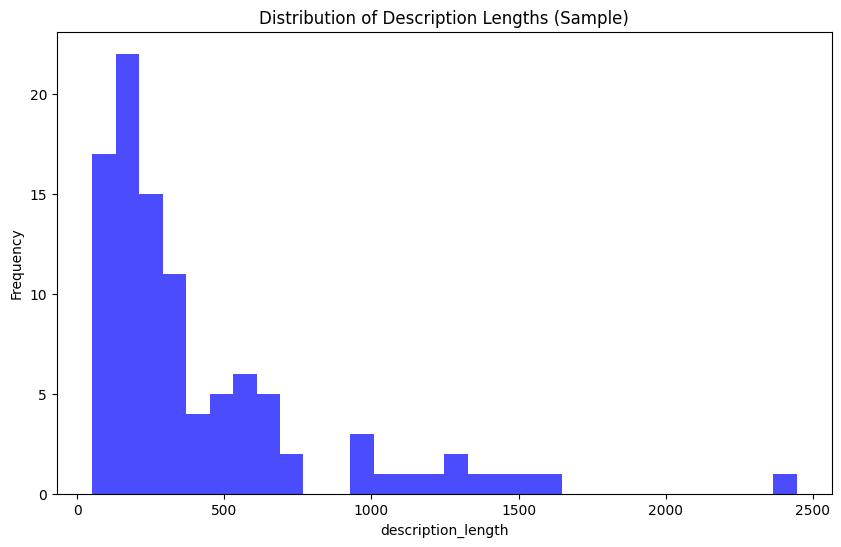

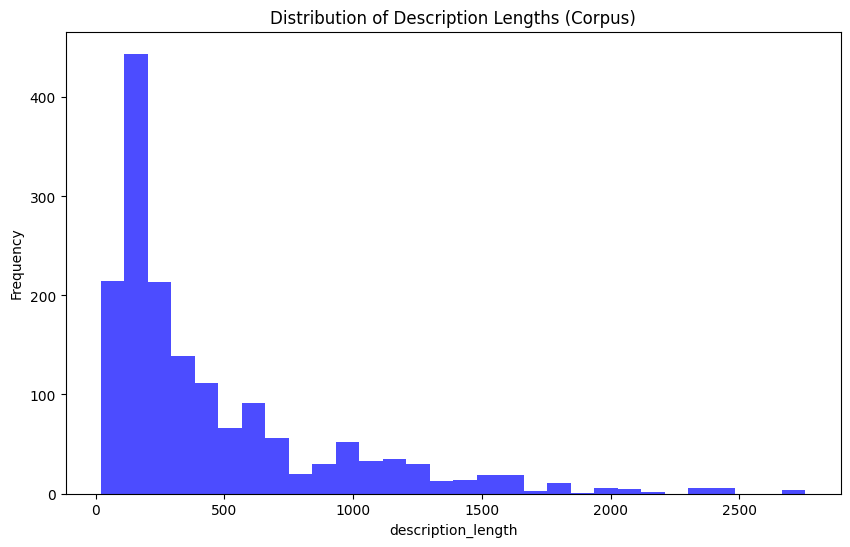

In [ ]:
# Plot distribution of description lengths for sample and corpus
df_sample['description_length'] = df_sample['combined_text'].str.len()
df_combined['description_length'] = df_combined['combined_text'].str.len()

plot_distribution(df_sample, 'description_length', 'Distribution of Description Lengths (Sample)')
plot_distribution(df_combined, 'description_length', 'Distribution of Description Lengths (Corpus)')




# Implementing recommendation system using different algorithms and check performance

##

# 1) Nearest Neighbor (NN) for recommendation (unsupervised-style) using entire dataset
Books are not predicted but similar books are recommended using KNN using the enire dataset considering the similarity of the books/nearest neighbors.

In [15]:
# NLP Recommender System
# Feature Normalization
# TF-IDF to convert the text data into numerical features suitable for machine learning
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_combined['processed_combined_text']) # use entire dataset

feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names
)

tfidf_df.head()


,000,10,100,1000,10a,10th,11,11th,12,13,...,欣颖,气候,爱好,精选英汉汉英词典,订机票,购物,轻松学中文,饮食,马亚敏,高校生活
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.089682,0.0,0.079342,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf_df.shape # there are 1646 rows

(1646, 5000)

In [17]:

# Define parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 6,10],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialize NearestNeighbors model
nn_model = NearestNeighbors()

# Perform grid search with cross-validation
grid_search = GridSearchCV(nn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(tfidf_matrix) # entire matrix is used. Labels not used since this is unsupervised method

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")



/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3}


Best parameters are 'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3

### Example usage

In [18]:
# Recommendation Function
def get_recommendations(description, model, tfidf_vectorizer, df):
    processed_text = preprocess_text(description)
    tfidf_desc = tfidf_vectorizer.transform([processed_text])
    distances, indices = model.kneighbors(tfidf_desc)
    recommendations = df.iloc[indices[0]]
    return recommendations

# Example usage
n = 300
description_to_recommend = df_combined['combined_text'].iloc[n] # select the description to recommend books
print(df_combined.iloc[n])
print("")

recommendations = get_recommendations(description_to_recommend, best_model, tfidf_vectorizer, df_combined)
print(f"Recommendations: {recommendations[['ISBN', 'title', 'School_ID', 'Year', 'Subject']]}")

categories                                                                  
ISBN                                                           9780190303488
title                      The Australian Integrated School Dictionary an...
authors                                                ['Oxford Dictionary']
description                Edited at the Australian National Dictionary C...
School_ID                                                                  7
State                                                                    VIC
Year                                                                       9
Subject                                                            LANGUAGES
combined_text              the australian integrated school dictionary an...
combined_text_length                                                     574
processed_combined_text    australian integrated school dictionary thesau...
Name: 300, dtype: object

Recommendations:               ISBN               

Using this approach we can recommend books. But the limitation is that everyime books to be recmmended to a new description, TF-IDF vecotor needs to be calculated. Therefore, best way is to train the model using training data and predict for the new description to predict books.   

# 2) NN for recommendation (unsupervised-style) using train/test split




### Split data to train and test



In [19]:
# Creating Train and Test Datasets
# Split data into train and test sets
# Dataset should be split before vectorizing to avoid data leakage.

# When stratified sampling the minimum number of groups for any class cannot be less than 2. Therefore, remove "HOME ECONOMICS" from the dataset
df_combined = df_combined[
    ~df_combined['Subject'].isin(['HOME ECONOMICS', 'PHILOSOPHY'])
]
train_data, test_data = train_test_split(df_combined, test_size=0.2, random_state=3, stratify=df_combined['Subject'])


In [20]:

# Fit the model on the training data

# tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['processed_combined_text'])
# best_model.fit(tfidf_matrix_train)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['processed_combined_text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['processed_combined_text']) # It uses the SAME vocabulary learned from training. It does NOT learn new words. Prevents data leakage

# Perform grid search with cross-validation with training dataset only
grid_search_train = GridSearchCV(nn_model, param_grid, cv=5, scoring='accuracy')
grid_search_train.fit(tfidf_matrix_train)

# Get the best parameters and model
best_params_train = grid_search_train.best_params_
best_model_train = grid_search_train.best_estimator_

print(f"Best fitted parameters considering only training set: {best_params_train}")

Best fitted parameters considering only training set: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

Best parameters are 'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3

### Example usage

In [23]:
# Example usage
n=200 # test data example to check the recommender system
print(f"print test data: {test_data.iloc[n]}")

description_to_recommend = test_data['combined_text'].iloc[n] # select the description to recommend books
recommendations_train = get_recommendations(description_to_recommend, best_model_train, tfidf_vectorizer, train_data)

print("")
print("Recommended books based on the description:")
print(recommendations_train[['ISBN', 'title', 'School_ID', 'Year', 'Subject']])

print test data: categories                                                                  
ISBN                                                           9780730389422
title                      Jacaranda Key Concepts in VCE Business Managem...
authors                    ['Stephen J. Chapman', 'Vladimir Dumovic', 'Ma...
description                                                                 
School_ID                                                                 10
State                                                                    VIC
Year                                                                       7
Subject                                                            LANGUAGES
combined_text              jacaranda key concepts in vce business managem...
combined_text_length                                                     418
processed_combined_text    jacaranda key concept vce business management ...
Name: 676, dtype: object

Recommended books based on the de

### Predicting the subject and evaluation using the first neighbor

In [24]:
# Evaluation
# Using precision and recall for evaluation
def evaluate_recommender(test_data, model, tfidf_vectorizer, train_data):
    y_true = []
    y_pred = []
    for index, row in test_data.iterrows():
        recommendations = get_recommendations(row['combined_text'], model, tfidf_vectorizer, train_data)
        true_subject = row['Subject']
        predicted_subjects = recommendations['Subject'].values
        y_true.append(true_subject)
        y_pred.append(predicted_subjects[0])  # Assuming the first recommendation is the prediction
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, accuracy, f1


In [25]:

# Evaluate the recommender system
precision, recall, accuracy, f1 = evaluate_recommender(test_data, best_model_train, tfidf_vectorizer, train_data)
print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}, F1_score: {f1}")


Precision: 0.7313113843071425, Recall: 0.6661371518173047, Accuracy: 0.817629179331307, F1_score: 0.6831777402102723


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As above, the model will get a custome book description from test set and shows the k nearest neighbors data from the training set. Subject, Year and other information related to the description can be derived from the first neighbor details.

So given a book description it hasn't seen before, it predicts what school subject that book belongs to — like ENGLISH, MATHEMATICS, SCIENCE etc. (you had 14 unique subjects in your dataset).  In practical terms, this means the system could be used to:

Automatically categorise a new book into a school subject based on its description
Recommend books from the same subject area to teachers or students
Help a school library tag uncategorised books

The core assumption is that books with similar descriptions belong to the same subject, which is why TF-IDF similarity works as the basis for prediction.

# 3) Predict the subject for a given description using supervised ML algorithm - KNN


In [21]:
# Label encode y before fitting knn
le = LabelEncoder()
y_train_enc = le.fit_transform(train_data['Subject'])
y_test_enc  = le.transform(test_data['Subject'])

In [27]:
# Fit the model on the training data

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix_knn = tfidf_vectorizer.fit_transform(train_data['processed_combined_text'])

knn = KNeighborsClassifier()

# Perform grid search with cross-validation with training dataset only
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(tfidf_matrix_train, y_train_enc)

# Get the best parameters and model
best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_

print(f"Best fitted parameters usin KNN classification: {best_params_knn}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with spa

Best fitted parameters usin KNN classification: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3}


Best parameters are 'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors':3

In [28]:
# Evaluate the recommender system
predict_knn = best_model_knn.predict(tfidf_matrix_test)
precision_knn = precision_score(y_test_enc, predict_knn, average='macro')
recall_knn = recall_score(y_test_enc, predict_knn, average='macro')
accuracy_knn = accuracy_score(y_test_enc, predict_knn)
f1_knn = f1_score(y_test_enc, predict_knn, average='macro')

#precision_knn, recall_knn, accuracy_knn, f1_knn = evaluate_recommender(test_data, best_model_knn, tfidf_vectorizer, train_data)
print(f"Precision: {precision_knn}, Recall: {recall_knn}, Accuracy: {accuracy_knn}, F1_score: {f1_knn}")

Precision: 0.5531506036023265, Recall: 0.5435209507786228, Accuracy: 0.7720364741641338, F1_score: 0.5329579060519558


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 4) Predict the subject for a given description using SVM(supervised) ML algorithm
  SVM works extremely well with high-dimensional sparse data (TF-IDF)

In [24]:
param_grid_svm = {
    "C": [0.1, 1, 5],
    "class_weight": ['balanced', None]

}

In [25]:
# Fit the model on the training data

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix_svm = tfidf_vectorizer.fit_transform(train_data['processed_combined_text'])

svm = LinearSVC()

# Perform grid search with cross-validation with training dataset only
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(tfidf_matrix_train, y_train_enc)

# Get the best parameters and model
best_params_svm = grid_search_svm.best_params_
best_model_svm = grid_search_svm.best_estimator_

print(f"Best fitted parameters usin SVM classification: {best_params_svm}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best fitted parameters usin SVM classification: {'C': 1, 'class_weight': None}


In [26]:
# Evaluate the recommender system

predict_svm = best_model_svm.predict(tfidf_matrix_test)
precision_svm = precision_score(y_test_enc, predict_svm, average='macro')
recall_svm = recall_score(y_test_enc, predict_svm, average='macro')
accuracy_svm = accuracy_score(y_test_enc, predict_svm)
f1_svm = f1_score(y_test_enc, predict_svm, average='macro')

print(f"Precision: {precision_svm}, Recall: {recall_svm}, Accuracy: {accuracy_svm}, F1_score: {f1_svm}")


Precision: 0.758861565920565, Recall: 0.6679734340764578, Accuracy: 0.8389057750759878, F1_score: 0.6953110771076633


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Predict books from training data
# Recommendation Function
def get_recommendations_svm(description, model, tfidf_vectorizer, df):
    processed_text = preprocess_text(description)
    tfidf_desc = tfidf_vectorizer.transform([processed_text])
    subject = model.predict(tfidf_desc)
    print("")
    print(f"Predicted subject: {le.inverse_transform(subject)}")
    recommendations = train_data[train_data['Subject'] == le.inverse_transform(subject)[0]]
    return recommendations

# Example usage
n = 20
description_to_recommend = test_data['combined_text'].iloc[n] # select the description to recommend books
print("Selected description from test data")
print(test_data.iloc[n])
print("")

recommendations = get_recommendations_svm(description_to_recommend, best_model_svm, tfidf_vectorizer, train_data)
print("")
print(f"Recommendations: {recommendations[['ISBN', 'title', 'School_ID', 'Year', 'Subject']]}")

Selected description from test data
categories                                                           ['Art']
ISBN                                                           9781742163505
title                                                              Artwise 2
authors                                                    ['Glenis Israel']
description                This new edition of Artwise 2: Visual Arts 9-1...
School_ID                                                                 27
State                                                                    ACT
Year                                                                      10
Subject                                                          VISUAL ARTS
combined_text              artwise 2 artwise 2 artwise 2 glenis israel gl...
combined_text_length                                                    1698
processed_combined_text    artwise 2 artwise 2 artwise 2 glenis israel gl...
Name: 1369, dtype: object


Predicted su

####Conclusion:
Considering all models, SVM and NN (unsupervised) shows the best performance. Unlike NN
method, SVM tries to find a hyperplane that separates classes in the high-dimensional TF-IDF
space. Also, it doesn’t memorize training samples and it learns a decision boundary. Therefore, it
has higher generalizability to new combinations of words that it hasn’t seen exactly before. By
considering both performance and the generalizability, SVM was selected as the best model for
the recommendation system to predict subject and recommend similar books based on a given
description.  


# Save the model and the vectorizer in picke format to deploy as an app in Streamlit

In [44]:
# create pickel files
import joblib
import pickle
joblib.dump(best_model_svm, "best_model_svm.pkl")


['best_model_svm.pkl']

In [45]:
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [46]:
joblib.dump(train_data, "train_data.pkl")

['train_data.pkl']

In [47]:
joblib.dump(le, "le.pkl")

['le.pkl']

In [52]:
# download the model and vectorizer and the book meta data
from google.colab import files
files.download("best_model_svm.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
files.download("tfidf_vectorizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
files.download("train_data.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
files.download("le.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>